In [1]:
from swwae_trainer import SWWAETrainer
from trainer import Trainer
from swwae import get_swwae
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import KFold
import torch
from torch.optim import lr_scheduler
import gc
import random


fold_num = 5
random.seed(519)
np.random.seed(519)
kf = KFold(n_splits=fold_num, shuffle=True, random_state=519)
is_transfer_learning = False
gc.enable()

# Train DAE

In [3]:
train_df = pd.read_json('Data/polar_split_no_denoise_processed_train.json')
train_df.sort_index(inplace=True)
print(train_df.shape)

(1604, 3)


# Test Model

In [4]:
model = get_swwae() #paperResNet18() #lessFilterResNet50()
model_name = 'Trained_model/swwae.db'

data_augmentation_args = {
    'mirror': False, # not useful here
    'rotate': True,
    'scale': True,
    'translation': True,
    'crop': False,
    #'color jitter' : True,
}

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

tr = SWWAETrainer(
        model,
        optimizer,
        epochs=150, 
        milestones=[50, 100],
        gamma=0.1,
        batch_size=128, 
        use_cuda=True, 
        gpu_idx=0,
        best_model_name=model_name,
        verbose=0)

tr.train(train_df, valid_df=None, is_transfer_learning=is_transfer_learning, 
         bce_weight=1., rec_loss_weight=.4,  rec_loss_weight_m=.4,    
         data_augmentation_args=data_augmentation_args, do_sa=False, t_start=0.005, start_epoch=1300)

tr.save(model_name)

gpu: 0  available: True
epoch= 1: Train loss: 0.723374, Accuracy: 1003/1604 (62.53%)
epoch= 2: Train loss: 0.628968, Accuracy: 1163/1604 (72.51%)
epoch= 3: Train loss: 0.565395, Accuracy: 1224/1604 (76.31%)
epoch= 4: Train loss: 0.518539, Accuracy: 1268/1604 (79.05%)
epoch= 5: Train loss: 0.500025, Accuracy: 1279/1604 (79.74%)
epoch= 6: Train loss: 0.477284, Accuracy: 1321/1604 (82.36%)
epoch= 7: Train loss: 0.466430, Accuracy: 1314/1604 (81.92%)
epoch= 8: Train loss: 0.433143, Accuracy: 1337/1604 (83.35%)
epoch= 9: Train loss: 0.447443, Accuracy: 1316/1604 (82.04%)
epoch= 10: Train loss: 0.441258, Accuracy: 1326/1604 (82.67%)
epoch= 11: Train loss: 0.425201, Accuracy: 1348/1604 (84.04%)
epoch= 12: Train loss: 0.408355, Accuracy: 1359/1604 (84.73%)
epoch= 13: Train loss: 0.403787, Accuracy: 1366/1604 (85.16%)
epoch= 14: Train loss: 0.391488, Accuracy: 1386/1604 (86.41%)
epoch= 15: Train loss: 0.397168, Accuracy: 1359/1604 (84.73%)
epoch= 16: Train loss: 0.391697, Accuracy: 1383/1604 (8

KeyboardInterrupt: 

Train images


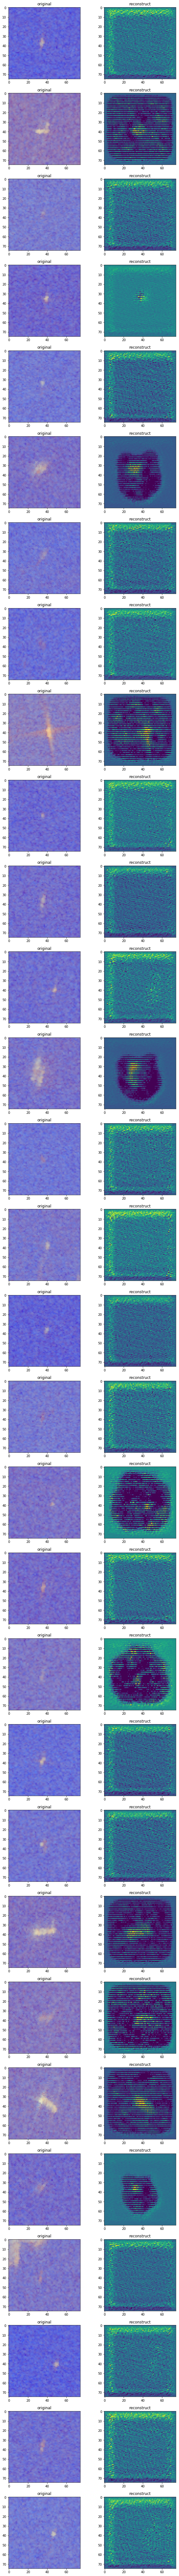

In [8]:
print('Train images')
preds, imgs = tr.test(train_df)
# plot some train images
show_num = 30
fig = plt.figure(1,figsize=(2*5,show_num*5))
for n in range(show_num):
    '''
    if train_df.loc[n, 'is_iceberg'] == True:
        name = 'Iceberg'
    else:
        name = 'Ship'
    '''
    ax = fig.add_subplot(show_num,2,2*n+1)
    #print(np.array(train_df.loc[n,'band']).shape)
    origin_img = np.array(train_df.loc[n,'band_mixed']).reshape((75,75,4))
    origin_img *= 255.0
    origin_img = origin_img.astype(np.uint8)
    ax.imshow(origin_img)#[14:62, 14:62]
    ax.set_title('original')

    ax = fig.add_subplot(show_num,2,2*n+2)
    #print(np.array(imgs[n]).shape)
    ax.imshow(imgs[n][:,:,1])
    ax.set_title('reconstruct')

In [ ]:
del optimizer, tr, model

# Cross validation

In [6]:
counter  = 1
for train_index, valid_index in kf.split(train_df):
   
    train = train_df.loc[train_index].reset_index(drop=True)
    valid = train_df.loc[valid_index].reset_index(drop=True)
    
    model = get_swwae() #paperResNet18() #lessFilterResNet50()
    model_name = 'Trained_model/swwae' + str(counter) + '.db'

    data_augmentation_args = {
        'mirror': False, # not useful here
        'rotate': True,
        'scale': True,
        'translation': True,
        'crop': False,
        #'color jitter' : True,
    }

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)

    tr = SWWAETrainer(
            model,
            optimizer,
            epochs=150, 
            milestones=[50, 100],
            gamma=0.1,
            batch_size=128, 
            use_cuda=True, 
            gpu_idx=0,
            best_model_name=model_name,
            verbose=0)

    tr.train(train, valid_df=valid, is_transfer_learning=is_transfer_learning, 
             bce_weight=1., rec_loss_weight=.8,  rec_loss_weight_m=.8,    
             data_augmentation_args=data_augmentation_args, do_sa=False, t_start=0.005, start_epoch=1300)

    
    del optimizer, tr, model
    gc.collect()    
    counter += 1

gpu: 0  available: True
epoch= 1: Train loss: 0.842202, Accuracy: 764/1283 (59.55%)
Valid set: loss: 0.709369, Accuracy: 152/321 (47.35%)
Best single model loss:  0.7093693614006042
epoch= 2: Train loss: 0.814220, Accuracy: 881/1283 (68.67%)
Valid set: loss: 0.688590, Accuracy: 169/321 (52.65%)
Best single model loss:  0.6885901689529419
epoch= 3: Train loss: 0.677195, Accuracy: 908/1283 (70.77%)
Valid set: loss: 0.694605, Accuracy: 164/321 (51.09%)
Best single model loss:  0.6885901689529419
epoch= 4: Train loss: 0.656714, Accuracy: 967/1283 (75.37%)
Valid set: loss: 0.769879, Accuracy: 137/321 (42.68%)
Best single model loss:  0.6885901689529419
epoch= 5: Train loss: 0.562126, Accuracy: 1017/1283 (79.27%)
Valid set: loss: 0.697808, Accuracy: 212/321 (66.04%)
Best single model loss:  0.6885901689529419
epoch= 6: Train loss: 0.602766, Accuracy: 1049/1283 (81.76%)
Valid set: loss: 0.506532, Accuracy: 245/321 (76.32%)
Best single model loss:  0.50653209288915
epoch= 7: Train loss: 0.5322

epoch= 103: Train loss: 0.316003, Accuracy: 1129/1283 (88.00%)
Valid set: loss: 0.244620, Accuracy: 287/321 (89.41%)
Best single model loss:  0.23996866742769876
epoch= 104: Train loss: 0.349628, Accuracy: 1123/1283 (87.53%)
Valid set: loss: 0.242000, Accuracy: 288/321 (89.72%)
Best single model loss:  0.23996866742769876
epoch= 105: Train loss: 0.341957, Accuracy: 1137/1283 (88.62%)
Valid set: loss: 0.241762, Accuracy: 287/321 (89.41%)
Best single model loss:  0.23996866742769876
epoch= 106: Train loss: 0.319648, Accuracy: 1130/1283 (88.07%)
Valid set: loss: 0.244309, Accuracy: 285/321 (88.79%)
Best single model loss:  0.23996866742769876
epoch= 107: Train loss: 0.341605, Accuracy: 1132/1283 (88.23%)
Valid set: loss: 0.244231, Accuracy: 287/321 (89.41%)
Best single model loss:  0.23996866742769876
epoch= 108: Train loss: 0.455857, Accuracy: 1139/1283 (88.78%)
Valid set: loss: 0.242854, Accuracy: 284/321 (88.47%)
Best single model loss:  0.23996866742769876
epoch= 109: Train loss: 0.38

epoch= 4: Train loss: 0.611036, Accuracy: 971/1283 (75.68%)
Valid set: loss: 0.840471, Accuracy: 169/321 (52.65%)
Best single model loss:  0.692568838596344
epoch= 5: Train loss: 0.629798, Accuracy: 988/1283 (77.01%)
Valid set: loss: 0.866825, Accuracy: 174/321 (54.21%)
Best single model loss:  0.692568838596344
epoch= 6: Train loss: 0.603366, Accuracy: 978/1283 (76.23%)
Valid set: loss: 0.385514, Accuracy: 273/321 (85.05%)
Best single model loss:  0.38551382223765057
epoch= 7: Train loss: 0.533509, Accuracy: 1029/1283 (80.20%)
Valid set: loss: 0.425082, Accuracy: 260/321 (81.00%)
Best single model loss:  0.38551382223765057
epoch= 8: Train loss: 0.483291, Accuracy: 1036/1283 (80.75%)
Valid set: loss: 0.320711, Accuracy: 270/321 (84.11%)
Best single model loss:  0.32071053981781006
epoch= 9: Train loss: 0.633441, Accuracy: 1070/1283 (83.40%)
Valid set: loss: 0.296115, Accuracy: 283/321 (88.16%)
Best single model loss:  0.2961152990659078
epoch= 10: Train loss: 0.475205, Accuracy: 1058/

Valid set: loss: 0.235694, Accuracy: 289/321 (90.03%)
Best single model loss:  0.21979126830895743
epoch= 56: Train loss: 0.345468, Accuracy: 1142/1283 (89.01%)
Valid set: loss: 0.247534, Accuracy: 289/321 (90.03%)
Best single model loss:  0.21979126830895743
epoch= 57: Train loss: 0.312455, Accuracy: 1144/1283 (89.17%)
Valid set: loss: 0.231386, Accuracy: 291/321 (90.65%)
Best single model loss:  0.21979126830895743
epoch= 58: Train loss: 0.300983, Accuracy: 1142/1283 (89.01%)
Valid set: loss: 0.230544, Accuracy: 290/321 (90.34%)
Best single model loss:  0.21979126830895743
epoch= 59: Train loss: 0.460416, Accuracy: 1127/1283 (87.84%)
Valid set: loss: 0.235721, Accuracy: 292/321 (90.97%)
Best single model loss:  0.21979126830895743
epoch= 60: Train loss: 0.304585, Accuracy: 1144/1283 (89.17%)
Valid set: loss: 0.228237, Accuracy: 293/321 (91.28%)
Best single model loss:  0.21979126830895743
epoch= 61: Train loss: 0.339414, Accuracy: 1146/1283 (89.32%)
Valid set: loss: 0.232813, Accurac

Valid set: loss: 0.214348, Accuracy: 293/321 (91.28%)
Best single model loss:  0.21234328548113504
epoch= 107: Train loss: 0.377996, Accuracy: 1164/1283 (90.72%)
Valid set: loss: 0.220362, Accuracy: 293/321 (91.28%)
Best single model loss:  0.21234328548113504
epoch= 108: Train loss: 0.454019, Accuracy: 1158/1283 (90.26%)
Valid set: loss: 0.214442, Accuracy: 294/321 (91.59%)
Best single model loss:  0.21234328548113504
epoch= 109: Train loss: 0.253785, Accuracy: 1166/1283 (90.88%)
Valid set: loss: 0.215866, Accuracy: 294/321 (91.59%)
Best single model loss:  0.21234328548113504
epoch= 110: Train loss: 0.367637, Accuracy: 1158/1283 (90.26%)
Valid set: loss: 0.214797, Accuracy: 294/321 (91.59%)
Best single model loss:  0.21234328548113504
epoch= 111: Train loss: 0.281085, Accuracy: 1142/1283 (89.01%)
Valid set: loss: 0.216400, Accuracy: 292/321 (90.97%)
Best single model loss:  0.21234328548113504
epoch= 112: Train loss: 0.254720, Accuracy: 1170/1283 (91.19%)
Valid set: loss: 0.217741, A

epoch= 7: Train loss: 0.658978, Accuracy: 1026/1283 (79.97%)
Valid set: loss: 0.400913, Accuracy: 256/321 (79.75%)
Best single model loss:  0.40091272195180255
epoch= 8: Train loss: 0.541386, Accuracy: 1017/1283 (79.27%)
Valid set: loss: 0.417712, Accuracy: 264/321 (82.24%)
Best single model loss:  0.40091272195180255
epoch= 9: Train loss: 0.541463, Accuracy: 1011/1283 (78.80%)
Valid set: loss: 0.410525, Accuracy: 260/321 (81.00%)
Best single model loss:  0.40091272195180255
epoch= 10: Train loss: 0.537719, Accuracy: 1003/1283 (78.18%)
Valid set: loss: 1.496717, Accuracy: 200/321 (62.31%)
Best single model loss:  0.40091272195180255
epoch= 11: Train loss: 0.570139, Accuracy: 988/1283 (77.01%)
Valid set: loss: 0.390973, Accuracy: 262/321 (81.62%)
Best single model loss:  0.39097336928049725
epoch= 12: Train loss: 0.576784, Accuracy: 1026/1283 (79.97%)
Valid set: loss: 0.338507, Accuracy: 275/321 (85.67%)
Best single model loss:  0.3385070264339447
epoch= 13: Train loss: 0.524538, Accura

epoch= 109: Train loss: 0.298382, Accuracy: 1140/1283 (88.85%)
Valid set: loss: 0.213136, Accuracy: 293/321 (91.28%)
Best single model loss:  0.21313641468683878
epoch= 110: Train loss: 0.323843, Accuracy: 1133/1283 (88.31%)
Valid set: loss: 0.211793, Accuracy: 292/321 (90.97%)
Best single model loss:  0.2117925782998403
epoch= 111: Train loss: 0.290199, Accuracy: 1139/1283 (88.78%)
Valid set: loss: 0.221421, Accuracy: 292/321 (90.97%)
Best single model loss:  0.2117925782998403
epoch= 112: Train loss: 0.416469, Accuracy: 1129/1283 (88.00%)
Valid set: loss: 0.227957, Accuracy: 292/321 (90.97%)
Best single model loss:  0.2117925782998403
epoch= 113: Train loss: 0.285658, Accuracy: 1137/1283 (88.62%)
Valid set: loss: 0.223381, Accuracy: 292/321 (90.97%)
Best single model loss:  0.2117925782998403
epoch= 114: Train loss: 0.346374, Accuracy: 1131/1283 (88.15%)
Valid set: loss: 0.231071, Accuracy: 289/321 (90.03%)
Best single model loss:  0.2117925782998403
epoch= 115: Train loss: 0.308745,

epoch= 10: Train loss: 0.557193, Accuracy: 1037/1283 (80.83%)
Valid set: loss: 0.383753, Accuracy: 264/321 (82.24%)
Best single model loss:  0.38375333944956463
epoch= 11: Train loss: 0.491971, Accuracy: 1049/1283 (81.76%)
Valid set: loss: 0.466773, Accuracy: 248/321 (77.26%)
Best single model loss:  0.38375333944956463
epoch= 12: Train loss: 0.509365, Accuracy: 1024/1283 (79.81%)
Valid set: loss: 0.523430, Accuracy: 241/321 (75.08%)
Best single model loss:  0.38375333944956463
epoch= 13: Train loss: 0.452442, Accuracy: 1047/1283 (81.61%)
Valid set: loss: 0.375271, Accuracy: 261/321 (81.31%)
Best single model loss:  0.37527114152908325
epoch= 14: Train loss: 0.438832, Accuracy: 1082/1283 (84.33%)
Valid set: loss: 0.325880, Accuracy: 268/321 (83.49%)
Best single model loss:  0.3258804678916931
epoch= 15: Train loss: 0.444490, Accuracy: 1090/1283 (84.96%)
Valid set: loss: 0.353264, Accuracy: 266/321 (82.87%)
Best single model loss:  0.3258804678916931
epoch= 16: Train loss: 0.459753, Acc

epoch= 61: Train loss: 0.425103, Accuracy: 1129/1283 (88.00%)
Valid set: loss: 0.265844, Accuracy: 278/321 (86.60%)
Best single model loss:  0.25313448905944824
epoch= 62: Train loss: 0.301730, Accuracy: 1137/1283 (88.62%)
Valid set: loss: 0.268966, Accuracy: 283/321 (88.16%)
Best single model loss:  0.25313448905944824
epoch= 63: Train loss: 0.380748, Accuracy: 1132/1283 (88.23%)
Valid set: loss: 0.272394, Accuracy: 275/321 (85.67%)
Best single model loss:  0.25313448905944824
epoch= 64: Train loss: 0.313237, Accuracy: 1143/1283 (89.09%)
Valid set: loss: 0.264228, Accuracy: 277/321 (86.29%)
Best single model loss:  0.25313448905944824
epoch= 65: Train loss: 0.320495, Accuracy: 1147/1283 (89.40%)
Valid set: loss: 0.269338, Accuracy: 275/321 (85.67%)
Best single model loss:  0.25313448905944824
epoch= 66: Train loss: 0.289154, Accuracy: 1138/1283 (88.70%)
Valid set: loss: 0.274419, Accuracy: 276/321 (85.98%)
Best single model loss:  0.25313448905944824
epoch= 67: Train loss: 0.323502, A

epoch= 112: Train loss: 0.270205, Accuracy: 1159/1283 (90.34%)
Valid set: loss: 0.245960, Accuracy: 280/321 (87.23%)
Best single model loss:  0.24595976372559866
epoch= 113: Train loss: 0.287195, Accuracy: 1140/1283 (88.85%)
Valid set: loss: 0.255019, Accuracy: 279/321 (86.92%)
Best single model loss:  0.24595976372559866
epoch= 114: Train loss: 0.368422, Accuracy: 1145/1283 (89.24%)
Valid set: loss: 0.246332, Accuracy: 281/321 (87.54%)
Best single model loss:  0.24595976372559866
epoch= 115: Train loss: 0.332281, Accuracy: 1147/1283 (89.40%)
Valid set: loss: 0.247330, Accuracy: 278/321 (86.60%)
Best single model loss:  0.24595976372559866
epoch= 116: Train loss: 0.310390, Accuracy: 1147/1283 (89.40%)
Valid set: loss: 0.247529, Accuracy: 281/321 (87.54%)
Best single model loss:  0.24595976372559866
epoch= 117: Train loss: 0.387294, Accuracy: 1147/1283 (89.40%)
Valid set: loss: 0.251922, Accuracy: 281/321 (87.54%)
Best single model loss:  0.24595976372559866
epoch= 118: Train loss: 0.32

epoch= 13: Train loss: 0.529487, Accuracy: 1033/1284 (80.45%)
Valid set: loss: 0.315318, Accuracy: 269/320 (84.06%)
Best single model loss:  0.31531794865926105
epoch= 14: Train loss: 0.464064, Accuracy: 1039/1284 (80.92%)
Valid set: loss: 0.338632, Accuracy: 278/320 (86.88%)
Best single model loss:  0.31531794865926105
epoch= 15: Train loss: 0.433377, Accuracy: 1079/1284 (84.03%)
Valid set: loss: 0.307679, Accuracy: 274/320 (85.62%)
Best single model loss:  0.30767856041590375
epoch= 16: Train loss: 0.590048, Accuracy: 1064/1284 (82.87%)
Valid set: loss: 0.366025, Accuracy: 263/320 (82.19%)
Best single model loss:  0.30767856041590375
epoch= 17: Train loss: 0.418935, Accuracy: 1074/1284 (83.64%)
Valid set: loss: 0.309625, Accuracy: 281/320 (87.81%)
Best single model loss:  0.30767856041590375
epoch= 18: Train loss: 0.409103, Accuracy: 1089/1284 (84.81%)
Valid set: loss: 0.404923, Accuracy: 272/320 (85.00%)
Best single model loss:  0.30767856041590375
epoch= 19: Train loss: 0.510735, A

epoch= 64: Train loss: 0.398185, Accuracy: 1142/1284 (88.94%)
Valid set: loss: 0.225758, Accuracy: 293/320 (91.56%)
Best single model loss:  0.22126340866088867
epoch= 65: Train loss: 0.283560, Accuracy: 1148/1284 (89.41%)
Valid set: loss: 0.226451, Accuracy: 291/320 (90.94%)
Best single model loss:  0.22126340866088867
epoch= 66: Train loss: 0.291154, Accuracy: 1126/1284 (87.69%)
Valid set: loss: 0.242047, Accuracy: 292/320 (91.25%)
Best single model loss:  0.22126340866088867
epoch= 67: Train loss: 0.437852, Accuracy: 1144/1284 (89.10%)
Valid set: loss: 0.230859, Accuracy: 292/320 (91.25%)
Best single model loss:  0.22126340866088867
epoch= 68: Train loss: 0.410571, Accuracy: 1148/1284 (89.41%)
Valid set: loss: 0.233594, Accuracy: 292/320 (91.25%)
Best single model loss:  0.22126340866088867
epoch= 69: Train loss: 0.367514, Accuracy: 1139/1284 (88.71%)
Valid set: loss: 0.226167, Accuracy: 292/320 (91.25%)
Best single model loss:  0.22126340866088867
epoch= 70: Train loss: 0.359636, A

epoch= 115: Train loss: 0.262691, Accuracy: 1164/1284 (90.65%)
Valid set: loss: 0.225712, Accuracy: 292/320 (91.25%)
Best single model loss:  0.2104881008466085
epoch= 116: Train loss: 0.333023, Accuracy: 1153/1284 (89.80%)
Valid set: loss: 0.223583, Accuracy: 293/320 (91.56%)
Best single model loss:  0.2104881008466085
epoch= 117: Train loss: 0.310528, Accuracy: 1140/1284 (88.79%)
Valid set: loss: 0.225201, Accuracy: 292/320 (91.25%)
Best single model loss:  0.2104881008466085
epoch= 118: Train loss: 0.279739, Accuracy: 1143/1284 (89.02%)
Valid set: loss: 0.230662, Accuracy: 293/320 (91.56%)
Best single model loss:  0.2104881008466085
epoch= 119: Train loss: 0.318776, Accuracy: 1144/1284 (89.10%)
Valid set: loss: 0.239172, Accuracy: 292/320 (91.25%)
Best single model loss:  0.2104881008466085
epoch= 120: Train loss: 0.279967, Accuracy: 1158/1284 (90.19%)
Valid set: loss: 0.222401, Accuracy: 291/320 (90.94%)
Best single model loss:  0.2104881008466085
epoch= 121: Train loss: 0.272910, 

# Train the whole training data to get init weight before training to reconstruct including the 'real' test images

In [5]:
model = get_swwae() #paperResNet18() #lessFilterResNet50()
model_name = 'Trained_model/swwae.db'

data_augmentation_args = {
    'mirror': False, # not useful here
    'rotate': True,
    'scale': True,
    'translation': True,
    'crop': False,
    #'color jitter' : True,
}

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)

tr = SWWAETrainer(
        model,
        optimizer,
        epochs=150, 
        milestones=[50, 100],
        gamma=0.1,
        batch_size=128, 
        use_cuda=True, 
        gpu_idx=0,
        best_model_name=model_name,
        verbose=0)

tr.train(train_df, valid_df=None, is_transfer_learning=is_transfer_learning, 
         bce_weight=1., rec_loss_weight=.8,  rec_loss_weight_m=.8,    
         data_augmentation_args=data_augmentation_args, do_sa=False, t_start=0.005, start_epoch=1300)

tr.save(model_name)

gpu: 0  available: True
epoch= 1: Train loss: 0.787801, Accuracy: 1023/1604 (63.78%)
epoch= 2: Train loss: 0.636452, Accuracy: 1207/1604 (75.25%)
epoch= 3: Train loss: 0.563394, Accuracy: 1278/1604 (79.68%)
epoch= 4: Train loss: 0.501520, Accuracy: 1342/1604 (83.67%)
epoch= 5: Train loss: 0.510868, Accuracy: 1327/1604 (82.73%)
epoch= 6: Train loss: 0.480585, Accuracy: 1370/1604 (85.41%)
epoch= 7: Train loss: 0.451623, Accuracy: 1376/1604 (85.79%)
epoch= 8: Train loss: 0.435113, Accuracy: 1386/1604 (86.41%)
epoch= 9: Train loss: 0.451315, Accuracy: 1380/1604 (86.03%)
epoch= 10: Train loss: 0.439605, Accuracy: 1382/1604 (86.16%)
epoch= 11: Train loss: 0.417920, Accuracy: 1391/1604 (86.72%)
epoch= 12: Train loss: 0.423605, Accuracy: 1387/1604 (86.47%)
epoch= 13: Train loss: 0.413456, Accuracy: 1393/1604 (86.85%)
epoch= 14: Train loss: 0.386334, Accuracy: 1423/1604 (88.72%)
epoch= 15: Train loss: 0.380253, Accuracy: 1429/1604 (89.09%)
epoch= 16: Train loss: 0.389607, Accuracy: 1415/1604 (8

epoch= 133: Train loss: 0.195792, Accuracy: 1519/1604 (94.70%)
epoch= 134: Train loss: 0.184260, Accuracy: 1518/1604 (94.64%)
epoch= 135: Train loss: 0.171139, Accuracy: 1535/1604 (95.70%)
epoch= 136: Train loss: 0.175516, Accuracy: 1532/1604 (95.51%)
epoch= 137: Train loss: 0.162250, Accuracy: 1533/1604 (95.57%)
epoch= 138: Train loss: 0.169808, Accuracy: 1536/1604 (95.76%)
epoch= 139: Train loss: 0.171544, Accuracy: 1529/1604 (95.32%)
epoch= 140: Train loss: 0.176803, Accuracy: 1528/1604 (95.26%)
epoch= 141: Train loss: 0.186791, Accuracy: 1524/1604 (95.01%)
epoch= 142: Train loss: 0.178688, Accuracy: 1523/1604 (94.95%)
epoch= 143: Train loss: 0.181441, Accuracy: 1527/1604 (95.20%)
epoch= 144: Train loss: 0.179532, Accuracy: 1521/1604 (94.83%)
epoch= 145: Train loss: 0.162708, Accuracy: 1539/1604 (95.95%)
epoch= 146: Train loss: 0.167549, Accuracy: 1545/1604 (96.32%)
epoch= 147: Train loss: 0.181627, Accuracy: 1526/1604 (95.14%)
epoch= 148: Train loss: 0.182755, Accuracy: 1520/1604 (

# Reconstruct training

In [4]:
test_df = pd.read_json('Data/polar_no_denoise_processed_soft_pseudo_label_test.json', dtype={'inc_angle': str})
test_df.sort_index(inplace=True)
print(test_df.tail(5))
test_df.loc[:, 'inc_angle'] = pd.to_numeric(test_df['inc_angle'], errors='coerce')

                                             band_mixed inc_angle  is_iceberg
3420  [[[0.2838254857, 0.2678208845, 0.7161745143, 0...   41.8582    0.000013
3421  [[[0.26898563870000003, 0.2805313043, 0.731014...   45.2853    0.985860
3422  [[[0.2488573496, 0.2694870363, 0.7511426504000...   34.7955    0.000020
3423  [[[0.20624679680000002, 0.2375915774, 0.793753...   39.5032    0.005940
3424  [[[0.2248578528, 0.2215530665, 0.7751421472000...    33.638    0.998152


In [5]:
train_df = pd.concat([train_df, test_df]).reset_index(drop=True)
del test_df
print(train_df.shape)

(5029, 3)


In [6]:
model = get_swwae(l1weight=0.01) #paperResNet18() #lessFilterResNet50()
model_name = 'Trained_model/swwae_usl.db'

data_augmentation_args = {
    'mirror': False, # not useful here
    'rotate': True,
    'scale': True,
    'translation': True,
    'crop': False,
    #'color jitter' : True,
}

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)

tr = SWWAETrainer(
        model,
        optimizer,
        epochs=150, 
        milestones=[50, 100],
        gamma=0.1,
        batch_size=128, 
        use_cuda=True, 
        gpu_idx=0,
        best_model_name=model_name,
        verbose=0)

tr.load('Trained_model/swwae.db')

tr.train(train_df, valid_df=None, is_transfer_learning=is_transfer_learning, 
         bce_weight=0., rec_loss_weight=1.,  rec_loss_weight_m=.8,    
         data_augmentation_args=data_augmentation_args, do_sa=False, t_start=0.005, start_epoch=1300)

tr.save(model_name)

gpu: 0  available: True
epoch= 1: Train loss: 0.063340
epoch= 2: Train loss: 0.054657
epoch= 3: Train loss: 0.048877
epoch= 4: Train loss: 0.043968
epoch= 5: Train loss: 0.039981
epoch= 6: Train loss: 0.035358
epoch= 7: Train loss: 0.031961
epoch= 8: Train loss: 0.028950
epoch= 9: Train loss: 0.026479
epoch= 10: Train loss: 0.024565
epoch= 11: Train loss: 0.021874
epoch= 12: Train loss: 0.019957
epoch= 13: Train loss: 0.018200
epoch= 14: Train loss: 0.016544
epoch= 15: Train loss: 0.015232
epoch= 16: Train loss: 0.014165
epoch= 17: Train loss: 0.013192
epoch= 18: Train loss: 0.013014
epoch= 19: Train loss: 0.012754
epoch= 20: Train loss: 0.011694
epoch= 21: Train loss: 0.011269
epoch= 22: Train loss: 0.009593
epoch= 23: Train loss: 0.008227
epoch= 24: Train loss: 0.007355
epoch= 25: Train loss: 0.006639
epoch= 26: Train loss: 0.006177
epoch= 27: Train loss: 0.005697
epoch= 28: Train loss: 0.004982
epoch= 29: Train loss: 0.004231
epoch= 30: Train loss: 0.003867
epoch= 31: Train loss: 0.

Testing reconstructed images


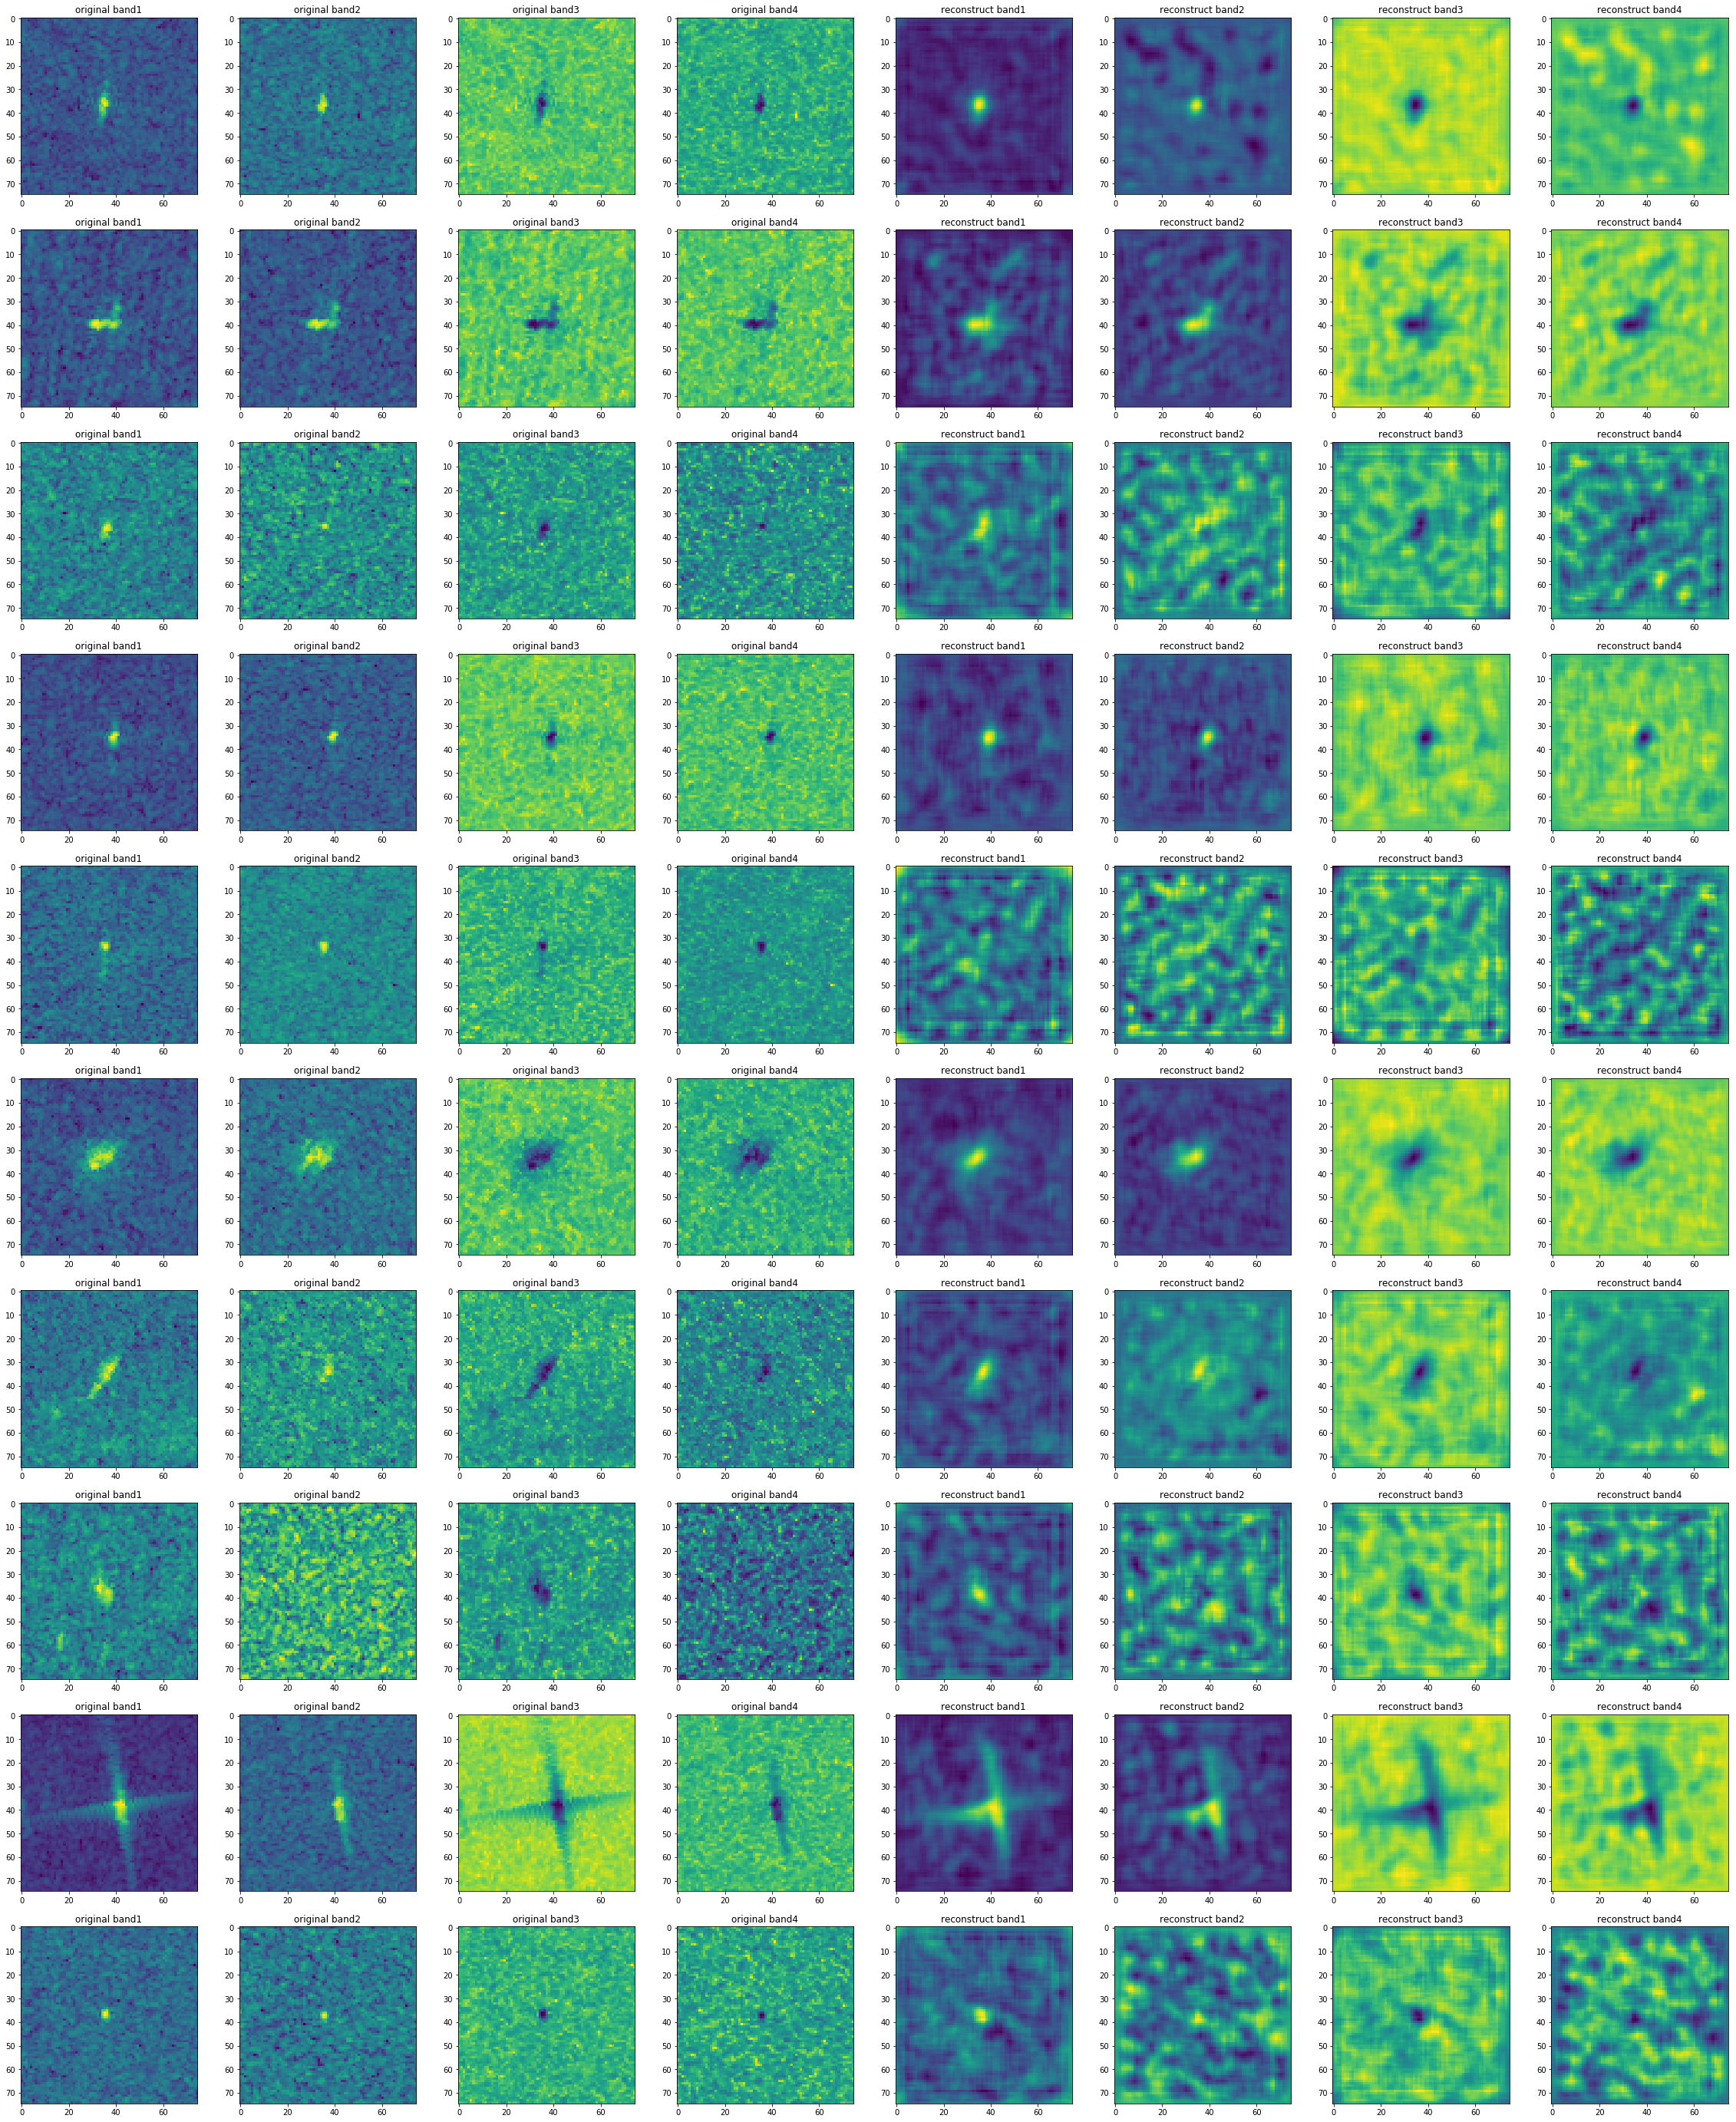

In [10]:
print('Testing reconstructed images')
preds, imgs = tr.test(train_df)
# plot some train images
show_num = 10
fig = plt.figure(1,figsize=(8*5,show_num*5))

for n in range(show_num):
    '''
    if train_df.loc[n, 'is_iceberg'] == True:
        name = 'Iceberg'
    else:
        name = 'Ship'
    '''
    #print(np.array(train_df.loc[n,'band']).shape)
    origin_img = np.array(train_df.loc[n,'band_mixed']).reshape((75,75,4))
    origin_img *= 255.0
    origin_img = origin_img.astype(np.uint8)
    
    ax = fig.add_subplot(show_num,8,8*n+1)
    ax.imshow(origin_img[:,:,0])#[14:62, 14:62]
    ax.set_title('original band1')
    
    ax = fig.add_subplot(show_num,8,8*n+2)
    ax.imshow(origin_img[:,:,1])#[14:62, 14:62]
    ax.set_title('original band2')
    
    ax = fig.add_subplot(show_num,8,8*n+3)
    ax.imshow(origin_img[:,:,2])#[14:62, 14:62]
    ax.set_title('original band3')
    
    ax = fig.add_subplot(show_num,8,8*n+4)
    ax.imshow(origin_img[:,:,3])#[14:62, 14:62]
    ax.set_title('original band4')

    ax = fig.add_subplot(show_num,8,8*n+5)
    #print(np.array(imgs[n]).shape)
    ax.imshow(imgs[n][:,:,0])
    ax.set_title('reconstruct band1')
    
    ax = fig.add_subplot(show_num,8,8*n+6)
    #print(np.array(imgs[n]).shape)
    ax.imshow(imgs[n][:,:,1])
    ax.set_title('reconstruct band2')
    
    ax = fig.add_subplot(show_num,8,8*n+7)
    #print(np.array(imgs[n]).shape)
    ax.imshow(imgs[n][:,:,2])
    ax.set_title('reconstruct band3')
    
    ax = fig.add_subplot(show_num,8,8*n+8)
    #print(np.array(imgs[n]).shape)
    ax.imshow(imgs[n][:,:,3])
    ax.set_title('reconstruct band4')

# Feature Extraction!

In [4]:
model = get_swwae(l1weight=0.01, feature_extract=True) #paperResNet18() #lessFilterResNet50()
model_name = 'Trained_model/swwae_usl.db'

data_augmentation_args = {}

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)

tr = SWWAETrainer(
        model,
        optimizer,
        epochs=150, 
        milestones=[50, 100],
        gamma=0.1,
        batch_size=128, 
        use_cuda=True, 
        gpu_idx=0,
        best_model_name=model_name,
        verbose=0)

tr.load(model_name)
preds = tr.test(train_df, is_feature_extract=True)

gpu: 0  available: True


In [5]:
columns = ['f_{}'.format(i) for i in range(preds.shape[1])]
transform_train = pd.DataFrame(data=preds,    # values
              columns=columns)  # 1st row as the column names
transform_train['is_iceberg'] = train_df['is_iceberg']
transform_train['inc_angle'] = train_df['inc_angle']
print(transform_train.head(10))

   f_0  f_1           f_2       f_3  f_4  f_5  f_6  f_7  f_8           f_9  \
0  0.0  0.0  5.221098e-41  0.012328  0.0  0.0  0.0  0.0  0.0  2.035429e-06   
1  0.0  0.0  5.221098e-41  0.000000  0.0  0.0  0.0  0.0  0.0  4.891148e-07   
2  0.0  0.0  5.221098e-41  0.023592  0.0  0.0  0.0  0.0  0.0  6.394656e-07   
3  0.0  0.0  5.221098e-41  0.006685  0.0  0.0  0.0  0.0  0.0  4.094703e-07   
4  0.0  0.0  5.221098e-41  0.000000  0.0  0.0  0.0  0.0  0.0  2.936333e-06   
5  0.0  0.0  5.221098e-41  0.000000  0.0  0.0  0.0  0.0  0.0  4.455305e-07   
6  0.0  0.0  5.221098e-41  0.015724  0.0  0.0  0.0  0.0  0.0  4.640173e-07   
7  0.0  0.0  5.221098e-41  0.010492  0.0  0.0  0.0  0.0  0.0  5.404121e-08   
8  0.0  0.0  5.221098e-41  0.000000  0.0  0.0  0.0  0.0  0.0  4.191188e-07   
9  0.0  0.0  5.221098e-41  0.000000  0.0  0.0  0.0  0.0  0.0  1.476602e-07   

     ...      f_1016        f_1017    f_1018  f_1019    f_1020  f_1021  \
0    ...         0.0  4.115283e-38  0.000328     0.0  0.000000     

In [6]:
new_cols = []
for c in columns:
    if len(np.unique(transform_train[c])) <= 1:
        continue
    else:
        new_cols.append(c)
new_cols.append('is_iceberg')
new_cols.append('inc_angle')
print('remain features: ', len(new_cols))
print(new_cols)

remain features:  216
['f_0', 'f_3', 'f_6', 'f_9', 'f_12', 'f_15', 'f_18', 'f_19', 'f_21', 'f_23', 'f_25', 'f_31', 'f_34', 'f_40', 'f_45', 'f_50', 'f_54', 'f_57', 'f_69', 'f_70', 'f_72', 'f_74', 'f_79', 'f_80', 'f_83', 'f_92', 'f_94', 'f_98', 'f_104', 'f_113', 'f_114', 'f_117', 'f_118', 'f_120', 'f_135', 'f_136', 'f_138', 'f_144', 'f_147', 'f_148', 'f_152', 'f_153', 'f_157', 'f_160', 'f_162', 'f_164', 'f_169', 'f_174', 'f_179', 'f_188', 'f_189', 'f_197', 'f_213', 'f_217', 'f_220', 'f_222', 'f_226', 'f_227', 'f_232', 'f_236', 'f_238', 'f_241', 'f_242', 'f_244', 'f_258', 'f_259', 'f_260', 'f_276', 'f_292', 'f_303', 'f_312', 'f_316', 'f_317', 'f_318', 'f_319', 'f_321', 'f_323', 'f_324', 'f_331', 'f_345', 'f_348', 'f_352', 'f_353', 'f_375', 'f_381', 'f_395', 'f_404', 'f_406', 'f_416', 'f_435', 'f_437', 'f_438', 'f_449', 'f_450', 'f_454', 'f_461', 'f_463', 'f_464', 'f_466', 'f_468', 'f_474', 'f_483', 'f_487', 'f_488', 'f_490', 'f_500', 'f_505', 'f_508', 'f_512', 'f_514', 'f_522', 'f_538', '

In [7]:
transform_train[new_cols].to_json('Data/sswae_gen_train.json')

In [8]:
del train_df, transform_train

In [10]:
test_df = pd.read_json('Data/polar_split_no_denoise_processed_test.json')

In [12]:
preds = tr.test(test_df, is_feature_extract=True)
columns = ['f_{}'.format(i) for i in range(preds.shape[1])]
transform_test = pd.DataFrame(data=preds,    # values
              columns=columns)  # 1st row as the column names
transform_test['is_iceberg'] = test_df['is_iceberg']
transform_test['inc_angle'] = test_df['inc_angle']
print(transform_test.head(10))

transform_test[new_cols].to_json('Data/sswae_gen_test.json')

   f_0  f_1           f_2       f_3  f_4  f_5  f_6  f_7  f_8           f_9  \
0  0.0  0.0  5.221098e-41  0.000000  0.0  0.0  0.0  0.0  0.0  1.695202e-07   
1  0.0  0.0  5.221098e-41  0.000000  0.0  0.0  0.0  0.0  0.0  2.370476e-06   
2  0.0  0.0  5.221098e-41  0.000000  0.0  0.0  0.0  0.0  0.0  3.945577e-07   
3  0.0  0.0  5.221098e-41  0.000000  0.0  0.0  0.0  0.0  0.0  3.596641e-06   
4  0.0  0.0  5.221098e-41  0.000000  0.0  0.0  0.0  0.0  0.0  5.823638e-06   
5  0.0  0.0  5.221098e-41  0.000000  0.0  0.0  0.0  0.0  0.0  9.996131e-06   
6  0.0  0.0  5.221098e-41  0.000000  0.0  0.0  0.0  0.0  0.0  9.867287e-07   
7  0.0  0.0  5.221098e-41  0.000000  0.0  0.0  0.0  0.0  0.0  1.101531e-06   
8  0.0  0.0  5.221098e-41  0.000000  0.0  0.0  0.0  0.0  0.0  2.370092e-06   
9  0.0  0.0  5.221098e-41  0.013415  0.0  0.0  0.0  0.0  0.0  1.537701e-06   

     ...      f_1016        f_1017    f_1018  f_1019    f_1020  f_1021  \
0    ...         0.0  4.115283e-38  0.000000     0.0  0.000000     

In [13]:
del test_df, transform_test

# Genrate final data

In [ ]:
train = pd.read_json('Data/train.json')
test = pd.read_json('Data/test.json')
all_df = pd.concat([train, test])
all_df.reset_index(inplace =True, drop=True)
print(all_df.shape)

In [ ]:
for band in ['band_1', 'band_2']:
    
    model = DAE() #paperResNet18() #lessFilterResNet50()
    model_name = 'Trained_model/dae.db'
  
    data_augmentation_args = {
        'mirror': False, # not useful here
        'rotate': True,
        'scale': True,
        'translation': True,
        'crop': False,
        #'color jitter' : True,
    }
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)

    tr = DAETrainer(
            model,
            optimizer,
            epochs=60, 
            milestones=[40],
            gamma=0.1,
            batch_size=32, 
            use_cuda=True, 
            gpu_idx=0,
            best_model_name=model_name,
            verbose=0)

    tr.train(all_df, valid_df=None, is_transfer_learning=is_transfer_learning, 
             data_augmentation_args=data_augmentation_args, do_sa=False, t_start=0.005, start_epoch=1300)
    
    #tr.load_checkpoint()
    
    imgs = tr.test(all_df)
    all_df['denoise' + band] = imgs
    
    # plot some test images
    show_num = 50
    fig = plt.figure(1,figsize=(2*5,show_num*5))
    for n in range(show_num):
        if all_df.loc[n, 'is_iceberg'] == True:
            name = 'Iceberg'
        else:
            name = 'Ship'
        ax = fig.add_subplot(show_num,2,2*n+1)
        ax.imshow(np.array(all_df.loc[n,'band']))#[14:62, 14:62]
        ax.set_title('original ({})'.format(name))

        ax = fig.add_subplot(show_num,2,2*n+2)
        ax.imshow(np.array(imgs[n]))
        ax.set_title('reconstruct')
    plt.show()

    
    del optimizer, tr, model

In [ ]:
band_3_min = None
band_3_max = None

band3_arr = []

for i, row in all_df.iterrows():
    band_1 = row['denoiseband_1']
    band_2 = row['denoiseband_2']
    
    band_3 = band_1 / band_2
    
    if band_3_min is None:
        band_3_min = band_3.min()
    else:
        band_3_min = min(band_3_min, band_3.min())
        
    if band_3_max is None:
        band_3_max = band_3.max()
    else:    
        band_3_max = max(band_3_max, band_3.max())
    
    band3_arr.append(band_3)

all_df['denoiseband_3'] =  [(band_3 - band_3_min) / (band_3_max - band_3_min) for band_3 in band3_arr]

In [ ]:
def color_composite(data):
    rgb_arrays = []
 
    for i, row in data.iterrows():
        band_1 = row['denoiseband_1']
        band_2 = row['denoiseband_2']
        band_3 = row['denoiseband_3']

        rgb = np.dstack((band_1, band_2, band_3))
        
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

In [ ]:
all_df['band_mixed'] = [img for img in color_composite(all_df)]

In [ ]:
fig = plt.figure(1,figsize=(20,45))
for i in range(9):
    ax = fig.add_subplot(9,4,4*i+1)
    arr = np.reshape(np.array(all_df.ix[i,'denoiseband_1']),(75,75))
    ax.imshow(arr)
    ax.set_title('band 1= ' + str(all_df.ix[i,'inc_angle']))
    
    ax = fig.add_subplot(9,4,4*i+2)
    arr = np.reshape(np.array(all_df.ix[i,'denoiseband_2']),(75,75))
    ax.imshow(arr)
    ax.set_title('band 2= ' + str(all_df.ix[i,'inc_angle']))
    
    ax = fig.add_subplot(9,4,4*i+3)
    arr = np.reshape(np.array(all_df.ix[i,'denoiseband_3']),(75,75))
    ax.imshow(arr)
    ax.set_title('band 3= ' + str(all_df.ix[i,'inc_angle']))
    
    ax = fig.add_subplot(9,4,4*i+4)
    arr = np.reshape(np.array(all_df.ix[i,'band_mixed']),(75,75,3))
    ax.imshow(arr)
    ax.set_title('band mixed= ' + str(all_df.ix[i,'inc_angle']))
    
    
plt.show()

In [ ]:
reserved_df = all_df[['band_mixed', 'inc_angle']]

In [ ]:
processed_train = reserved_df.iloc[:train.shape[0],]
processed_train['is_iceberg'] = train['is_iceberg']
processed_test = reserved_df.iloc[train.shape[0]:,]
processed_test['is_iceberg'] = np.zeros((test.shape[0],))

processed_train.reset_index(drop=True, inplace=True)
processed_test.reset_index(drop=True, inplace=True)

print(processed_train.shape, processed_test.shape)
print(test.iloc[0])
print(processed_test.iloc[0])

In [ ]:
processed_train.to_json('Data/dae_denoised_processed_train.json')
processed_test.to_json('Data/dae_denoised_processed_test.json')